<a href="https://colab.research.google.com/github/delte1821/ML-SERS/blob/master/ML_SERS_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, Activation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
print("Import process done")

Import process done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
class SERS:
    def __init__(self, file_path, display):
        self.file_path = file_path
        self.figure_path = os.path.join(file_path, "Figures")
        self.display = display
        self.fig_counter = 1  # Initialize a counter for figure saving

    def load_data(self, file_path):
        df = pd.read_excel(file_path, header=None)
        materials = df.iloc[0, :].astype(int)  # Ensure materials are integers
        concentrations = df.iloc[1, :].astype(float)
        data = df.iloc[2:, :].values
        return data, materials, concentrations

    def filter_by_material(self, data, materials, concentrations, material_type):
        indices = materials == material_type
        filtered_data = data[:, indices]
        filtered_concentrations = concentrations[indices]
        return filtered_data, filtered_concentrations

    def preprocess_data(self, data):
        nsamples, nx, ny = data.shape
        data_2d = data.reshape((nsamples, nx * ny))
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_2d)
        data_reshaped = data_scaled.reshape(nsamples, nx, ny)
        return data_reshaped

    def augment_data(self, data, labels, num_augmented_samples=5):
        augmented_data = []
        augmented_labels = []
        for sample, label in zip(data, labels):
            for _ in range(num_augmented_samples):
                noise = np.random.normal(0, 0.1, sample.shape)
                augmented_sample = sample + noise
                augmented_data.append(augmented_sample)
                augmented_labels.append(label)
        return np.array(augmented_data), np.array(augmented_labels)

    def build_cnn_model(self, input_shape):
        model = Sequential([
            Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling1D(2),
            Conv1D(64, kernel_size=3, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(2),
            Flatten(),
            Dense(100, activation='relu'),
            Dropout(0.5),
            Dense(1)  # Output layer for concentration prediction
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def remove_outliers(self, X, y):
        z_scores_X = (X - np.mean(X)) / np.std(X)
        z_scores_y = (y - np.mean(y)) / np.std(y)
        threshold = 3
        non_outliers_X = X[abs(z_scores_X) <= threshold]
        non_outliers_y = y[abs(z_scores_y) <= threshold]
        # Ensure both X and y have the same number of samples
        min_samples = min(len(non_outliers_X), len(non_outliers_y))

        non_outliers_X = non_outliers_X[:min_samples]
        non_outliers_y = non_outliers_y[:min_samples]

        # Replace the original data with the non-outliers
        X = non_outliers_X
        y = non_outliers_y
        return X, y

    def train_and_validate(self, data, materials, concentrations, material_types):
        results = {}
        for mat_type in material_types:
            X, y = self.filter_by_material(data, materials, concentrations, mat_type)
            #X, y = self.remove_outliers(X, y)
            X_train, X_val, y_train, y_val = train_test_split(X.T, y, test_size=0.2, random_state=42)
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

            # Data augmentation
            X_train, y_train = self.augment_data(X_train, y_train)

            X_train = self.preprocess_data(X_train)
            X_val = self.preprocess_data(X_val)

            model = self.build_cnn_model((X_train.shape[1], 1))
            print(f"Training model for material type: {mat_type}")
            history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)
            results[mat_type] = (mse, r2, model)

            if self.display:
                self.plot_predictions(y_val, y_pred, mat_type)
                self.plot_training_history(history, mat_type)

        # Increment counter after completing an analysis for all material types
        self.fig_counter += 1
        return results

    def plot_predictions(self, y_true, y_pred, material_type):
        material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
        plt.figure(figsize=(8, 6))
        plt.scatter(y_true, y_pred, c='blue')
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
        plt.xlabel('Actual Concentrations')
        plt.ylabel('Predicted Concentrations')
        plt.title(f'Actual vs Predicted Concentrations for {material_name}')
        r2 = r2_score(y_true, y_pred)
        plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
        plt.tight_layout()
        plt.savefig(os.path.join(self.figure_path, f'{material_name}_LR_{self.fig_counter}.png'))
        if self.display:
            plt.show()

    def plot_training_history(self, history, material_type):
        material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Epoch vs Loss for {material_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.figure_path, f'{material_name}_TH_{self.fig_counter}.png'))
        if self.display:
            plt.show()

    def classify_materials(self, data, materials):
        # Transpose data to match the materials length
        data = data.T

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)

        # Apply PCA
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(data_scaled)

        # Ensure the lengths match
        assert data_pca.shape[0] == len(materials), "Inconsistent number of samples between data and materials"

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(data_pca, materials, test_size=0.2, random_state=42)

        # Data augmentation for classification
        X_train, y_train = self.augment_data(X_train, y_train)

        # Encode labels
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_val_encoded = le.transform(y_val)

        # Train RandomForest Classifier
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train_encoded)
        y_pred = clf.predict(X_val)

        # Decode labels
        y_pred_decoded = le.inverse_transform(y_pred)

        # Convert integer labels to strings for classification_report
        target_names = [str(label) for label in le.classes_]

        # Print classification report
        print("Material Classification Report (Validation):")
        print(classification_report(y_val_encoded, y_pred, target_names=target_names))

        # Plot confusion matrix
        self.plot_confusion_matrix(y_val_encoded, y_pred, target_names)

    def plot_confusion_matrix(self, y_true, y_pred, labels):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.figure(figsize=(8, 6))
        plt.tight_layout()
        plt.savefig(os.path.join(self.figure_path, f'CM_{self.fig_counter}.png'))
        if self.display:
            plt.show()


In [5]:
# Paths and instantiation
file_path = "/content/drive/My Drive/Colab Notebooks/Spectra/Low"
original_file_path = os.path.join(file_path, "Combine.xlsx")
display = True
print(original_file_path)
print(os.listdir(file_path))

/content/drive/My Drive/Colab Notebooks/Spectra/Low/Combine.xlsx
['Wavelength.xlsx', 'IL6.xlsx', 'TNF.xlsx', 'Combine.xlsx', 'Figures']


Training model for material type: 1
Epoch 1/200
16/16 [==============================] - 2s 21ms/step - loss: 1099.3708 - val_loss: 1299.6115
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 612.5895 - val_loss: 1236.0312
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 614.7441 - val_loss: 1183.0580
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 586.9663 - val_loss: 1177.4568
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 548.7760 - val_loss: 1042.0289
Epoch 6/200
16/16 [==============================] - 0s 7ms/step - loss: 498.4951 - val_loss: 939.6443
Epoch 7/200
16/16 [==============================] - 0s 7ms/step - loss: 422.1988 - val_loss: 936.5363
Epoch 8/200
16/16 [==============================] - 0s 7ms/step - loss: 414.0879 - val_loss: 899.1697
Epoch 9/200
16/16 [==============================] - 0s 7ms/step - loss: 441.0204 - val_loss: 881.5031
Epoch 10/200
16/16 [==========

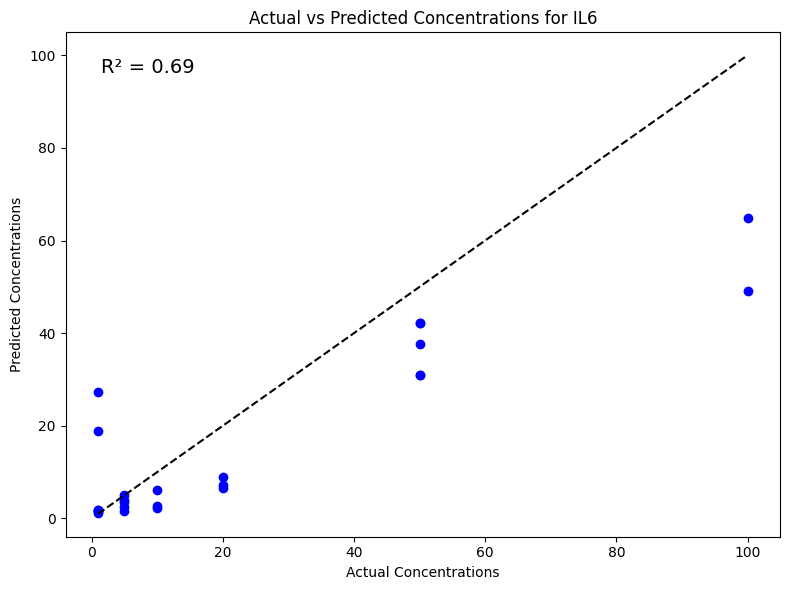

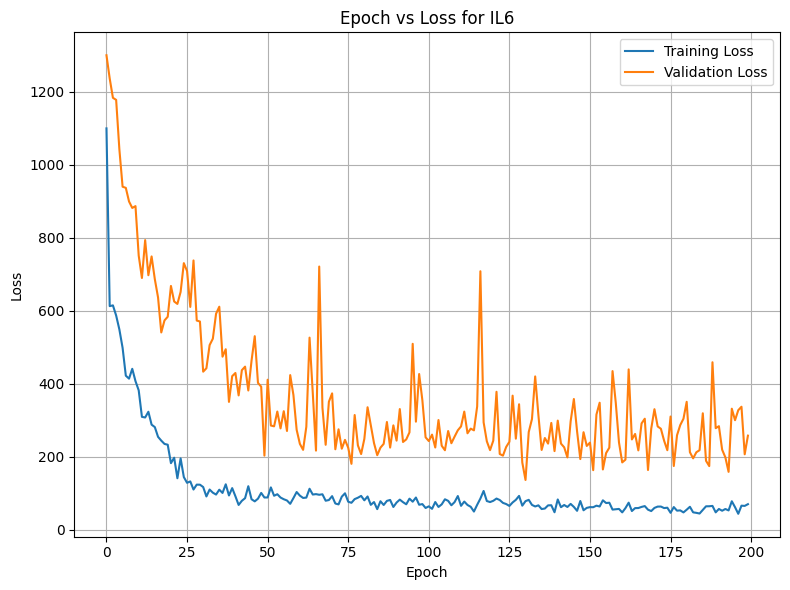

Training model for material type: 2
Epoch 1/200
10/10 [==============================] - 2s 28ms/step - loss: 3099.9663 - val_loss: 8347.4053
Epoch 2/200
10/10 [==============================] - 0s 9ms/step - loss: 1953.3577 - val_loss: 8240.3125
Epoch 3/200
10/10 [==============================] - 0s 9ms/step - loss: 1345.4609 - val_loss: 8076.4814
Epoch 4/200
10/10 [==============================] - 0s 11ms/step - loss: 879.1515 - val_loss: 7964.3657
Epoch 5/200
10/10 [==============================] - 0s 9ms/step - loss: 684.6449 - val_loss: 7903.6304
Epoch 6/200
10/10 [==============================] - 0s 9ms/step - loss: 568.5207 - val_loss: 7806.6084
Epoch 7/200
10/10 [==============================] - 0s 9ms/step - loss: 543.5211 - val_loss: 7777.6196
Epoch 8/200
10/10 [==============================] - 0s 8ms/step - loss: 432.6656 - val_loss: 7730.9263
Epoch 9/200
10/10 [==============================] - 0s 8ms/step - loss: 350.7328 - val_loss: 7642.9526
Epoch 10/200
10/10 [===

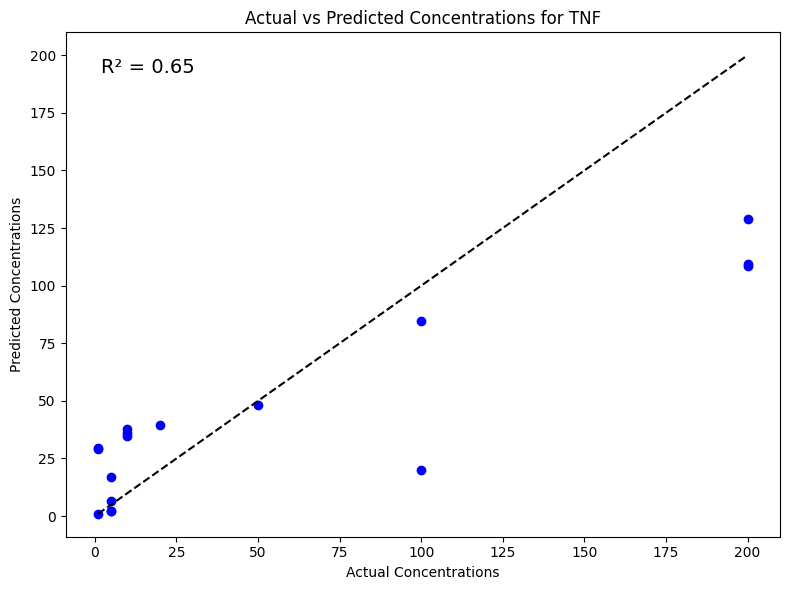

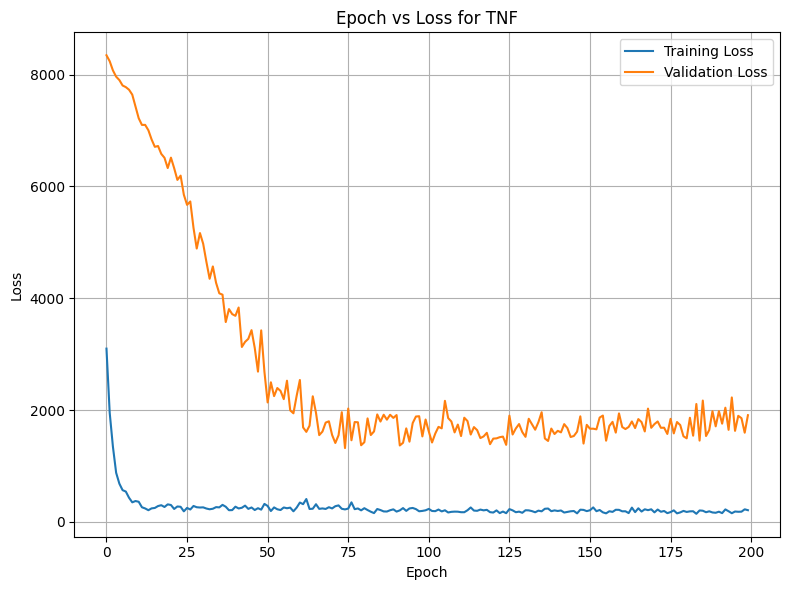

In [14]:
# Instantiate and use the model
sers_model = SERS(file_path, display=True)
data, materials, concentrations = sers_model.load_data(original_file_path)
material_types = [1, 2]  # Focusing on IL6 and TNF for example
results_regression = sers_model.train_and_validate(data, materials, concentrations, material_types)

Data shape after transpose: (232, 1024)
Materials length: 232
Material Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.91      0.95      0.93        22
           2       0.86      1.00      0.92        18

    accuracy                           0.87        47
   macro avg       0.81      0.75      0.75        47
weighted avg       0.85      0.87      0.85        47



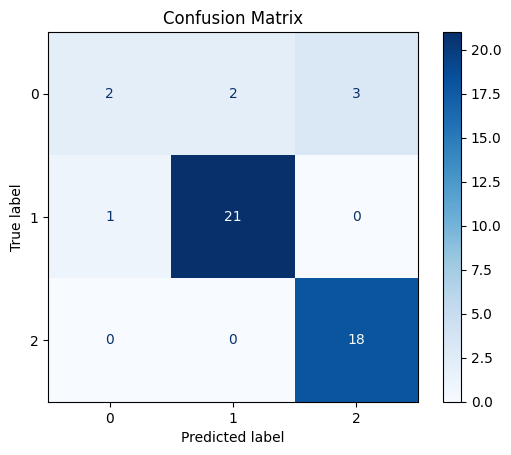

<Figure size 800x600 with 0 Axes>

In [16]:
# Check shapes
print("Data shape after transpose:", data.T.shape)
print("Materials length:", len(materials))
# Classification
sers_model.classify_materials(data, materials)